In [1]:
# import neccessary libraries
import os
import sys
import json
import requests
from tqdm import tqdm
import time
import datetime
import logging
import logging.handlers
import torch
import pandas as pd
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import os
from datasets import load_dataset
import torch.nn.parallel
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import matplotlib.pyplot as plt
import seaborn as sns

/home/mingxu/miniconda3/envs/ML/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import wandb
import random
wandb.init(
    project="DL_Lab3",
    config={
    "learning_rate": 5e-4,
    "architecture": "LSTM",
    "dataset": "NamedEntityRecognition",
    "liers": 2e4,
    "hidden_dim": 128,
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mingxu_zhang (mingxus-team). Use `wandb login --relogin` to force relogin


In [3]:
def findFiles(path): return glob.glob(path)
print(findFiles('names/*.txt'))
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['names/Italian.txt', 'names/Japanese.txt', 'names/Greek.txt', 'names/Arabic.txt', 'names/French.txt', 'names/Polish.txt', 'names/Czech.txt', 'names/Vietnamese.txt', 'names/English.txt', 'names/Irish.txt', 'names/Scottish.txt', 'names/Korean.txt', 'names/Russian.txt', 'names/Portuguese.txt', 'names/Dutch.txt', 'names/Spanish.txt', 'names/Chinese.txt', 'names/German.txt']
Slusarski


In [4]:
print(category_lines['Chinese'][:5])

['Ang', 'AuYong', 'Bai', 'Ban', 'Bao']


In [5]:
n_categories

18

In [6]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [7]:
def split_data(category_lines, split_ratio=0.8):
    train_data = {}
    test_data = {}

    for category, lines in category_lines.items():
        random.shuffle(lines)  # 打乱每个类别中的名字列表
        split_point = int(len(lines) * split_ratio)  # 计算划分点
        train_data[category] = lines[:split_point]
        test_data[category] = lines[split_point:]

    return train_data, test_data
train_data, test_data = split_data(category_lines, split_ratio=0.8)

In [8]:
train_data['Chinese'][:5]

['Won', 'Zhong', 'Chu', 'Guan', 'Juan']

In [9]:
test_data['Chinese'][:5]

['Hui', 'Tong', 'Thian', 'Xue', 'Liang']

In [10]:
def evaluate(model, category_lines, all_categories, n_letters, all_letters):
    model.eval()  # 将模型设置为评估模式
    actual, predictions = [], []

    with torch.no_grad():  # 在测试时不需要计算梯度
        for category in all_categories:
            for line in category_lines[category]:
                category_tensor = torch.zeros(1, len(all_categories))
                category_index = all_categories.index(category)
                category_tensor[0][category_index] = 1
                line_tensor = lineToTensor(line, n_letters, all_letters)
                output, _ = model(category_tensor, line_tensor[0], model.initHidden())
                prediction = output.argmax(dim=1).item()
                actual.append(category_index)
                predictions.append(prediction)

    return actual, predictions

In [11]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(output_size + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(output_size + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), dim=1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), dim=1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    def evaluate(self, test_data, all_categories, n_letters, all_letters):
        self.eval()  # Sets the module in evaluation mode
        correct = 0
        total = 0
        
        with torch.no_grad():  # No gradients needed
            for category in all_categories:
                for line in test_data[category]:
                    category_index = all_categories.index(category)
                    category_tensor = torch.zeros(1, len(all_categories))
                    category_tensor[0][category_index] = 1
                    line_tensor = lineToTensor(line, n_letters, all_letters)  # Make sure lineToTensor is accessible
                    output, _ = self(category_tensor, line_tensor[0], self.initHidden())
                    _, predicted = torch.max(output, 1)
                    total += 1
                    correct += (predicted == category_index).item()

        accuracy = correct / total
        return accuracy


In [12]:
def letterToIndex(letter, all_letters):
    return all_letters.find(letter)

def letterToTensor(letter, n_letters, all_letters):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter, all_letters)] = 1
    return tensor

def lineToTensor(line, n_letters, all_letters):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter, all_letters)] = 1
    return tensor


In [13]:
def train(rnn, category_tensor, line_tensor, category_index_tensor, criterion, optimizer):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    correct = 0  # 初始化 correct
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(category_tensor, line_tensor[i], hidden)
    loss = criterion(output, category_index_tensor)  # 确保这里使用的是类别索引张量
    wandb.log({"loss": loss.item()})
    loss.backward()
    optimizer.step()


    return output, loss.item()

def randomTrainingExample(train_data, all_categories, n_letters, all_letters):
    import random
    category = random.choice(all_categories)
    line = random.choice(train_data[category])
    category_index = all_categories.index(category)
    category_tensor = torch.tensor([category_index], dtype=torch.long)  # 类别索引
    category_one_hot = torch.zeros(1, len(all_categories))  # 创建一个全零的张量
    category_one_hot[0][category_index] = 1  # 将对应的类别索引设为 1
    line_tensor = lineToTensor(line, n_letters, all_letters)
    return category, line, category_tensor, category_one_hot, line_tensor


In [14]:
'''
n_hidden = 128
n_categories = len(all_categories)
n_letters = len(all_letters)
rnn = RNN(n_letters, n_hidden, n_categories)
print(f'n_letters: {n_letters}, n_hidden: {n_hidden}, n_categories: {n_categories}')


criterion = nn.NLLLoss()
optimizer = optim.SGD(rnn.parameters(), lr=5e-4)
accuracies = []
for i in tqdm(range(20000)):  
    category, line, category_index_tensor, category_tensor, line_tensor = randomTrainingExample(train_data, all_categories, n_letters, all_letters)
    output, loss = train(rnn, category_tensor, line_tensor, category_index_tensor, criterion, optimizer)
    if (i + 1) % 500 == 0:
        print(f'Iteration {i+1}, Loss: {loss}')
        test_accuracy = rnn.evaluate(test_data, all_categories, n_letters, all_letters)
        wandb.log({"accuracy": test_accuracy})
'''

n_letters: 57, n_hidden: 128, n_categories: 18


  2%|▏         | 485/20000 [00:00<00:29, 663.11it/s]

Iteration 500, Loss: 2.924936532974243


  5%|▍         | 942/20000 [00:02<00:33, 569.44it/s]

Iteration 1000, Loss: 2.9744925498962402


  7%|▋         | 1492/20000 [00:03<00:29, 623.92it/s]

Iteration 1500, Loss: 2.8173787593841553


 10%|▉         | 1965/20000 [00:04<00:31, 581.35it/s]

Iteration 2000, Loss: 2.854414224624634


 12%|█▏        | 2448/20000 [00:05<00:29, 590.68it/s]

Iteration 2500, Loss: 2.9237868785858154


 15%|█▍        | 2926/20000 [00:07<00:29, 583.28it/s]

Iteration 3000, Loss: 2.8132269382476807


 17%|█▋        | 3484/20000 [00:08<00:26, 634.23it/s]

Iteration 3500, Loss: 2.890239715576172


 20%|█▉        | 3962/20000 [00:09<00:27, 586.37it/s]

Iteration 4000, Loss: 2.7990992069244385


 22%|██▏       | 4436/20000 [00:11<00:27, 576.22it/s]

Iteration 4500, Loss: 2.7279586791992188


 25%|██▍       | 4989/20000 [00:12<00:23, 631.85it/s]

Iteration 5000, Loss: 2.7093963623046875


 27%|██▋       | 5464/20000 [00:13<00:25, 578.62it/s]

Iteration 5500, Loss: 2.794480085372925


 30%|██▉       | 5927/20000 [00:14<00:24, 573.37it/s]

Iteration 6000, Loss: 2.6951966285705566


 32%|███▏      | 6487/20000 [00:16<00:21, 640.11it/s]

Iteration 6500, Loss: 2.8245534896850586


 35%|███▍      | 6962/20000 [00:17<00:22, 585.04it/s]

Iteration 7000, Loss: 2.6725521087646484


 37%|███▋      | 7429/20000 [00:18<00:22, 566.95it/s]

Iteration 7500, Loss: 2.590848684310913


 40%|███▉      | 7982/20000 [00:20<00:19, 626.72it/s]

Iteration 8000, Loss: 2.57106614112854


 42%|████▏     | 8468/20000 [00:21<00:19, 593.43it/s]

Iteration 8500, Loss: 2.60355281829834


 45%|████▍     | 8938/20000 [00:22<00:19, 576.39it/s]

Iteration 9000, Loss: 2.5054659843444824


 47%|████▋     | 9424/20000 [00:23<00:18, 583.79it/s]

Iteration 9500, Loss: 2.6568727493286133


 50%|████▉     | 9974/20000 [00:25<00:16, 619.15it/s]

Iteration 10000, Loss: 2.4832513332366943


 52%|█████▏    | 10455/20000 [00:26<00:16, 590.43it/s]

Iteration 10500, Loss: 2.5321624279022217


 55%|█████▍    | 10940/20000 [00:27<00:15, 588.84it/s]

Iteration 11000, Loss: 2.7279086112976074


 57%|█████▋    | 11499/20000 [00:29<00:13, 631.55it/s]

Iteration 11500, Loss: 2.6404192447662354


 60%|█████▉    | 11974/20000 [00:30<00:13, 583.41it/s]

Iteration 12000, Loss: 2.573728084564209


 62%|██████▏   | 12454/20000 [00:31<00:12, 585.90it/s]

Iteration 12500, Loss: 1.7056050300598145


 65%|██████▍   | 12930/20000 [00:32<00:12, 580.04it/s]

Iteration 13000, Loss: 0.21434439718723297


 67%|██████▋   | 13486/20000 [00:34<00:10, 632.28it/s]

Iteration 13500, Loss: 2.573406219482422


 70%|██████▉   | 13962/20000 [00:35<00:10, 581.35it/s]

Iteration 14000, Loss: 1.2370802164077759


 72%|███████▏  | 14443/20000 [00:36<00:09, 584.83it/s]

Iteration 14500, Loss: 0.8426050543785095


 75%|███████▍  | 14994/20000 [00:38<00:08, 621.33it/s]

Iteration 15000, Loss: 2.498898983001709


 77%|███████▋  | 15460/20000 [00:39<00:07, 568.12it/s]

Iteration 15500, Loss: 1.81837797164917


 80%|███████▉  | 15936/20000 [00:40<00:06, 582.87it/s]

Iteration 16000, Loss: 1.2656989097595215


 82%|████████▏ | 16493/20000 [00:41<00:05, 628.90it/s]

Iteration 16500, Loss: 2.1175856590270996


 85%|████████▍ | 16980/20000 [00:43<00:05, 597.86it/s]

Iteration 17000, Loss: 2.280694007873535


 87%|████████▋ | 17437/20000 [00:44<00:04, 553.28it/s]

Iteration 17500, Loss: 2.140357732772827


 90%|████████▉ | 17992/20000 [00:45<00:03, 625.75it/s]

Iteration 18000, Loss: 0.8717455267906189


 92%|█████████▏| 18475/20000 [00:47<00:02, 590.40it/s]

Iteration 18500, Loss: 0.09052955359220505


 95%|█████████▍| 18944/20000 [00:48<00:01, 569.63it/s]

Iteration 19000, Loss: 1.8576549291610718


 97%|█████████▋| 19495/20000 [00:49<00:00, 627.44it/s]

Iteration 19500, Loss: 0.0


100%|█████████▉| 19973/20000 [00:50<00:00, 592.73it/s]

Iteration 20000, Loss: 1.826544165611267


100%|██████████| 20000/20000 [00:51<00:00, 387.22it/s]


In [15]:
import torch
from sklearn.metrics import confusion_matrix
import numpy as np

actual, predictions = evaluate(rnn, test_data, all_categories, n_letters, all_letters)
cm = confusion_matrix(actual, predictions)

row_sums = cm.sum(axis=1)
norm_cm = cm / row_sums[:, np.newaxis]  # 规范化混淆矩阵


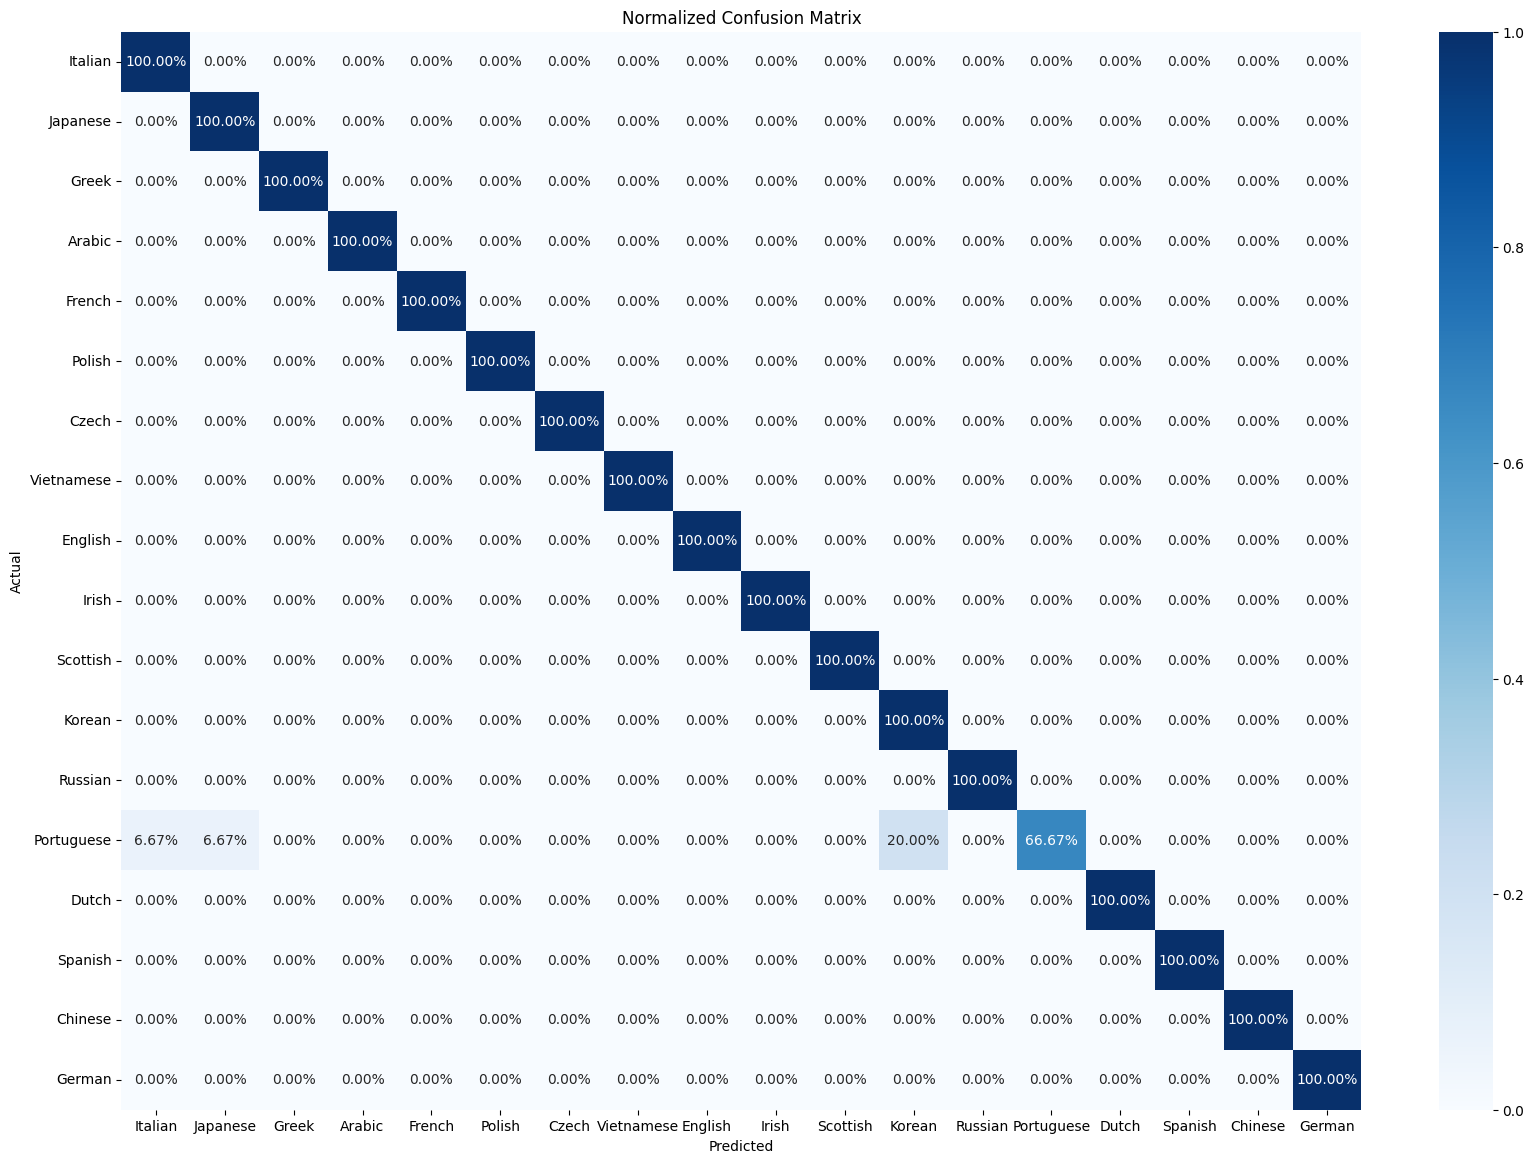

In [16]:
plt.figure(figsize=(20, 14))
sns.heatmap(norm_cm, annot=True, fmt=".2%", cmap='Blues',
            xticklabels=all_categories, yticklabels=all_categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')
plt.show()


In [19]:
# save the model
torch.save(rnn.state_dict(), 'RNN_2e4_5e-4.pth')